In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.models.model import VSpyct
from src.utils import (calculate_bs, fix_predictions, plot_brier)
from src.data.dataset import SurvivalDataset

/Users/viktorandonovic/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = SurvivalDataset(fname='pbc.rda', path='../data/raw/')
print(data.dataset.head())
X_train, X_test, y_train, y_test = data.get_tensors()

   id  time  status trt        age sex ascites hepato spiders  edema  bili  \
0   1   400       2   1  58.765229   f       1      1       1    1.0  14.5   
1   2  4500       0   1  56.446270   f       0      1       1    0.0   1.1   
2   3  1012       2   1  70.072553   m       0      0       0    0.5   1.4   
3   4  1925       2   1  54.740589   f       0      1       1    0.5   1.8   
4   5  1504       1   2  38.105407   f       0      1       1    0.0   3.4   

  chol  albumin copper  alk.phos     ast trig platelet  protime stage  
0  261     2.60    156    1718.0  137.95  172      190     12.2     4  
1  302     4.14     54    7394.8  113.52   88      221     10.6     3  
2  176     3.48    210     516.0   96.10   55      151     12.0     4  
3  244     2.54     64    6121.8   60.63   92      183     10.3     4  
4  279     3.53    143     671.0  113.15   72      136     10.9     3  
4795
Succesfully created time tensor of shape: torch.Size([418, 4795])
(334, 769) torch.Size([334, 

In [117]:
model = VSpyct(max_depth=3, bs=64)
model.fit(X_train, y_train)

Total variance: 127.46780395507812


KeyError: "None of [Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,\n       ...\n       172, 173, 174, 175, 176, 177, 178, 179, 180, 181],\n      dtype='int64', length=182)] are in the [columns]"

In [91]:
preds = model.predict(X_test)

In [92]:
X_train, T_train, E_train, X_test, T_test, E_test = data.pysurvival_split('time', 'status')

In [93]:
avg_preds = preds.mean(axis=1)

In [94]:
y_test.shape, avg_preds.shape

(torch.Size([46, 1022]), torch.Size([46, 1022]))

In [95]:
# class Brier:
#   def __init__(self, times, event_observed):
#     from lifelines import KaplanMeierFitter
#     self.times = times
#     self.event_observed = event_observed
#     self.num_events = sum(event_observed)
#     self.kmf = KaplanMeierFitter()
#     self.kmf.fit(self.times, self.event_observed)
#     cumulative_censoring_probs = 1 - self.kmf.survival_function_.values
#     self.ipcw_coeffs = (1 / cumulative_censoring_probs)[1:]

#   def evaluate(self, times_arr, predicted_probs):
#     if isinstance(times_arr, torch.Tensor): times_arr = times_arr.numpy()
#     if isinstance(predicted_probs, torch.Tensor): predicted_probs = predicted_probs.numpy()
#     print(np.power(times_arr - predicted_probs, 2).mean(axis=0).shape)
#     brier_score = (self.ipcw_coeffs*np.power(times_arr - predicted_probs, 2)).mean(axis=0) / self.num_events
#     return brier_score

In [96]:
from src import eval

In [187]:
import numpy as np
from lifelines import KaplanMeierFitter

class IPCWBrierScoreCalculator:
    def __init__(self, times, event_observed):
        self.times = times
        self.event_observed = event_observed
        self.kmf_event = KaplanMeierFitter()
        self.kmf_censor = KaplanMeierFitter()

        # Fit KM estimator for event
        self.kmf_event.fit(times, event_observed)
        
        # Fit KM estimator for censoring (invert event_observed)
        self.kmf_censor.fit(times, ~event_observed)

    def ipcw(self):
        """Calculate the Inverse Probability of Censoring Weights (IPCW)."""
        # Probabilities of not being censored
        probs_not_censored = self.kmf_censor.survival_function_at_times(self.times).values
        
        # Handle division by zero
        probs_not_censored = np.clip(probs_not_censored, 1e-10, 1)
        
        # Calculate IPCW
        return 1 / probs_not_censored

    def brier_score(self, prediction_times, predicted_survival):
      prediction_times = np.asarray(prediction_times)
      predicted_survival = np.asarray(predicted_survival)
      
      # IPCW for each observation
      ipcw_weights = self.ipcw()

      print(prediction_times.shape, predicted_survival.shape)

      # Observed - Predicted survival squared, weighted by IPCW
      weighted_diff_squared = ipcw_weights * (prediction_times - predicted_survival) ** 2
      
      # Average over all observations to get Brier Score
      brier_score = np.mean(weighted_diff_squared, axis=0)
      
      return brier_score

In [188]:
import sys
sys.path.append('..')
from src.utils import fix_predictions
from src.data.dataset import SurvivalDataset
import numpy as np
import torch

class IPCWBrier:
    def __init__(self, times, event_observed):
        from lifelines import KaplanMeierFitter
        from scipy.interpolate import interp1d
        self.times = times
        self.event_observed = event_observed
        self.num_events = sum(event_observed)
        self.kmf = KaplanMeierFitter()
        self.kmf.fit(self.times, self.event_observed)
        
        # Calculate cumulative censoring probabilities
        cumulative_censoring_probs = 1 - self.kmf.survival_function_.values.flatten()
        
        # Get the time points corresponding to the survival function estimates
        kmf_times = self.kmf.survival_function_.index.values
        
        # Interpolate to match the original number of time points
        # Create an interpolation function based on the kmf times and the cumulative censoring probabilities
        interp_func = interp1d(kmf_times, cumulative_censoring_probs, fill_value="extrapolate")
        
        # Use the interpolation function to estimate ipcw_coeffs for each original time point
        self.ipcw_coeffs = interp_func(self.times)
        
        # Adjust any values that might be extrapolated beyond the range of 0 to 1
        self.ipcw_coeffs = np.clip(self.ipcw_coeffs, 0, 1)
        
        # Inverse to get IPCW coefficients
        self.ipcw_coeffs = 1 / self.ipcw_coeffs
        print(self.ipcw_coeffs.shape)

    def evaluate(self, times_arr, predicted_probs):
        if isinstance(times_arr, torch.Tensor): times_arr = times_arr.numpy()
        if isinstance(predicted_probs, torch.Tensor): predicted_probs = predicted_probs.numpy()
        diff = torch.tensor(np.power(times_arr - predicted_probs, 2))
        print(diff.shape)
        ipcw_coeffs = torch.tensor(self.ipcw_coeffs, dtype=torch.float32)  # Ensure it's a PyTorch tensor
        ipcw_coeffs = ipcw_coeffs.unsqueeze(-1)
        brier_score = torch.nanmean(ipcw_coeffs * diff, axis=0) / self.num_events
        return brier_score



In [189]:
_bs_ = IPCWBrierScoreCalculator(T_test, E_test)
bs_vspyct = _bs_.brier_score(y_test, avg_preds)
plt.plot(bs_vspyct)

(46, 1022) (46, 1022)
[[ 0.  0.  0. ... nan nan nan]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... nan nan nan]
 ...
 [ 0.  0.  0. ... nan nan nan]
 [ 0.  0.  0. ... nan nan nan]
 [ 0.  0.  0. ... nan nan nan]]


ValueError: operands could not be broadcast together with shapes (46,) (46,1022) 

In [100]:
from pysurvival.models.multi_task import LinearMultiTaskModel
mtlr = LinearMultiTaskModel()
mtlr.fit(X_train, T_train, E_train, lr=0.0001, l2_reg=1e-2, init_method='zeros')

predicted_mtlr = mtlr.predict_survival(X_test)
transformed_predictions_mtlr = fix_predictions(predicted_mtlr, mtlr.times, int(T_train.max()))

% Completion: 100%|***********************************************|Loss: 514.83


torch.Size([46, 1022])


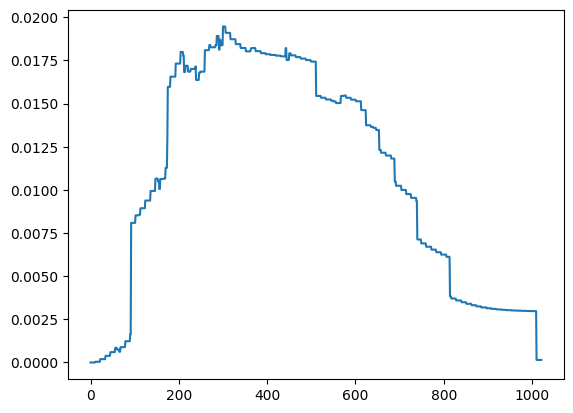

In [103]:
bs_mtlr = _bs_.evaluate(y_test, transformed_predictions_mtlr)
plt.plot(bs_mtlr)

In [104]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel

rsf = RandomSurvivalForestModel(num_trees=50)
rsf.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=5)

RandomSurvivalForestModel

In [105]:
predicted_rsf = rsf.predict_survival(X_test)
transformed_predictions_rsf = fix_predictions(predicted_rsf, rsf.times, int(T_train.max()))

torch.Size([46, 1022])


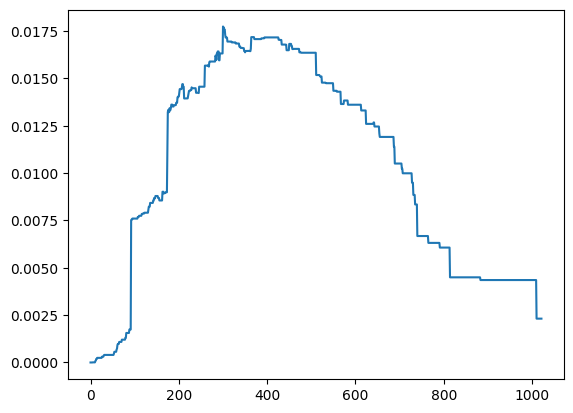

In [106]:
bs_rsf = _bs_.evaluate(y_test, transformed_predictions_rsf)
plt.plot(bs_rsf)

In [107]:
from pysurvival.models.semi_parametric import CoxPHModel

coxph = CoxPHModel()
coxph.fit(X_train, T_train, E_train, lr=0.01, l2_reg=1e-2, init_method='zeros')

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 559.875 - ||grad||^2 = 83.29303
 * Iteration #2 - Loss = 559.480 - ||grad||^2 = 82.45950
 * Iteration #3 - Loss = 559.093 - ||grad||^2 = 81.63433
 * Iteration #4 - Loss = 558.715 - ||grad||^2 = 80.81744
 * Iteration #5 - Loss = 558.344 - ||grad||^2 = 80.00873
 * Iteration #6 - Loss = 557.981 - ||grad||^2 = 79.20814
 * Iteration #7 - Loss = 557.626 - ||grad||^2 = 78.41558
 * Iteration #8 - Loss = 557.278 - ||grad||^2 = 77.63096
 * Iteration #9 - Loss = 556.937 - ||grad||^2 = 76.85421
 * Iteration #10 - Loss = 556.603 - ||grad||^2 = 76.08524
 * Iteration #11 - Loss = 556.276 - ||grad||^2 = 75.32399
 * Iteration #12 - Loss = 555.956 - ||grad||^2 = 74.57036
 * Iteration #13 - Loss = 555.642 - ||grad||^2 = 73.82429
 * Iteration #14 - Loss = 555.335 - ||grad||^2 = 73.08569
 * Iteration #15 - Loss = 555.034 - ||grad||^2 = 72.35450
 * Iteration #16 - Loss = 554.740 - ||grad||^2 = 71.63063
 * Iteration #17 - Loss = 554.451 - ||grad

CoxPHModel

In [108]:
predicted_coxph = coxph.predict_survival(X_test)
transformed_predictions_coxph = fix_predictions(predicted_coxph, coxph.times, int(T_train.max()))

In [109]:
bs_coxph = _bs_.evaluate(y_test, transformed_predictions_coxph)

torch.Size([46, 1022])


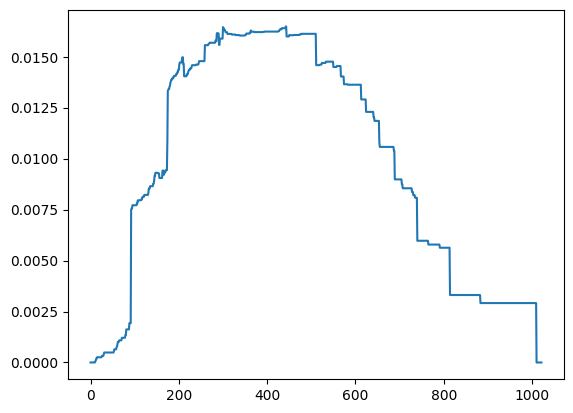

In [110]:
plt.plot(bs_coxph)

In [111]:
import spyct

model = spyct.Model()
model.fit(X_train.values, y_train.numpy())

In [112]:
preds_spyct = model.predict(y_test.numpy())

In [113]:
preds_spyct.shape

(46, 1022)

torch.Size([46, 1022])


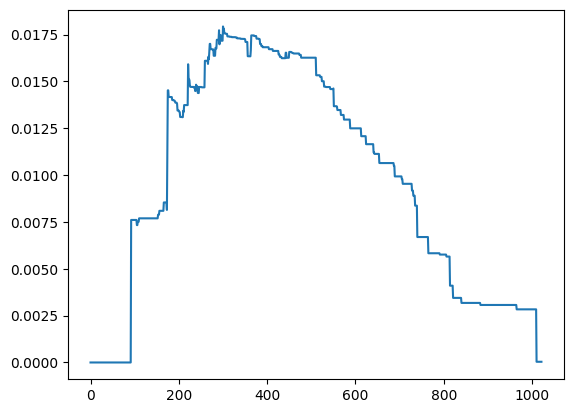

In [114]:
bs_spyct = _bs_.evaluate(y_test, preds_spyct)
plt.plot(bs_spyct)

In [115]:
import matplotlib.pyplot as plt

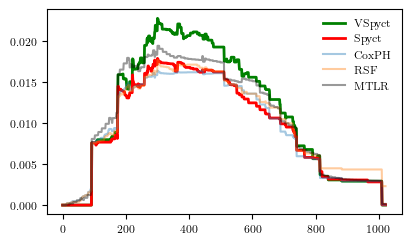

In [116]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
fig, ax = plt.subplots(figsize=(6/1.5,3.5/1.5))
fig.set_constrained_layout(True)

ax.plot(bs_vspyct, label='VSpyct', color='green', linewidth=2.0)
ax.plot(bs_spyct, label='Spyct', color='red', linewidth=2.0)
ax.plot(bs_coxph, label='CoxPH', alpha=0.4)
ax.plot(bs_rsf, label='RSF', alpha=0.4)
ax.plot(bs_mtlr, label='MTLR', alpha=0.4, color='k')
ax.legend(frameon=False)

# plt.savefig('../reports/figures/bs_rdata.pdf')

In [2]:
import pyreadr
dataset = pyreadr.read_r('../data/raw/cancer.rda')['cancer']#.split('/')[-1]]

In [3]:
dataset

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
rownames,,,,,,,,,,
1,3.0,306.0,2.0,74.0,1.0,1.0,90.0,100.0,1175.0,NaN
2,3.0,455.0,2.0,68.0,1.0,0.0,90.0,90.0,1225.0,15.0
3,3.0,1010.0,1.0,56.0,1.0,0.0,90.0,90.0,NaN,15.0
4,5.0,210.0,2.0,57.0,1.0,1.0,90.0,60.0,1150.0,11.0
5,1.0,883.0,2.0,60.0,1.0,0.0,100.0,90.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
224,1.0,188.0,1.0,77.0,1.0,1.0,80.0,60.0,NaN,3.0
225,13.0,191.0,1.0,39.0,1.0,0.0,90.0,90.0,2350.0,-5.0
226,32.0,105.0,1.0,75.0,2.0,2.0,60.0,70.0,1025.0,5.0


In [160]:
y_test.shape

torch.Size([46, 1022])

In [158]:
data = SurvivalDataset(fname='cancer.rda', path='../data/raw/')
print(data.dataset.head())
X_train, X_test, y_train, y_test = data.get_tensors('time', 'status')

          inst    time  status   age  sex  ph.ecog  ph.karno  pat.karno  \
rownames                                                                  
1          3.0   306.0     2.0  74.0  1.0      1.0      90.0      100.0   
2          3.0   455.0     2.0  68.0  1.0      0.0      90.0       90.0   
3          3.0  1010.0     1.0  56.0  1.0      0.0      90.0       90.0   
4          5.0   210.0     2.0  57.0  1.0      1.0      90.0       60.0   
5          1.0   883.0     2.0  60.0  1.0      0.0     100.0       90.0   

          meal.cal  wt.loss  
rownames                     
1           1175.0      NaN  
2           1225.0     15.0  
3              NaN     15.0  
4           1150.0     11.0  
5              NaN      0.0  
1022
Succesfully created time tensor of shape: torch.Size([228, 1022])
(182, 8) torch.Size([182, 1022])


Next steps:

1) Adjust the VSpyct model to account for missing target variables. It should work in a SSL manner, same as the original SPYCT - FIXED 
2) Add PyCox models to the game - TODO 
3) Do the evaluations with 5-fold CV - TODO 

In [351]:
def gen_surv_nan(num_samples, num_days=365, missing_prob=0.1, nan_start_day=200):
    num_features = 5  # Replace with the actual number of features

    X = np.random.rand(num_samples, num_features)

    y = np.zeros((num_samples, num_days))
    for i in range(num_samples):
        survival_prob = np.linspace(1, 0, num_days) * np.random.uniform(0.5, 1.5)

        # Introduce missing values after the specified time point
        nan_start_day = min(nan_start_day, num_days)  # Ensure nan_start_day is within the valid range
        missing_indices = np.arange(nan_start_day, num_days)
        y[i, missing_indices] = np.nan

        y[i, :nan_start_day] = survival_prob[:nan_start_day]

    return X, y

def generate_survival_function_data(num_samples, num_days=365):
  X = np.random.rand(num_samples, num_features)  

  y = np.zeros((num_samples, num_days))
  for i in range(num_samples):
    y[i] = np.linspace(1, 0, num_days) * np.random.uniform(0.5, 1.5)

  return X, y

In [160]:
print(fake_weights.shape, y.shape)
print(torch.matmul(fake_weights, y[:,0]))

torch.Size([1000]) torch.Size([1000, 365])
tensor(-6.4459)


In [224]:
def weighted_variance(values, weights, weight_sum):
    mean = torch.matmul(weights, values) / weight_sum
    return -torch.sum(mean*mean)

In [225]:
def wvar(values, weights, weight_sum):
    _list = []
    for i in range(values.shape[1]):
        valid_indices = ~torch.isnan(values[:, i])
        _list.append(torch.matmul(weights[valid_indices], values[valid_indices, i]))
    _list = [z**2 for z in [x/weight_sum.item() for x in _list]]
    return -(sum(_list))

In [347]:
def _wvar(values, weights, weight_sum):
    valid_indices = ~torch.isnan(values)
    weighted_values = values * weights.view(-1, 1)
    weighted_values[~valid_indices] = 0  # Set invalid values to 0
    variance = ((weighted_values.sum(dim=0) / weight_sum) ** 2).sum()
    return -variance

In [353]:
_wvar(y, fake_weights, torch.sum(fake_weights))

tensor(-168.5716)

In [354]:
weighted_variance(y, fake_weights, torch.sum(fake_weights))

tensor(nan)

In [355]:
wvar(y, fake_weights, torch.sum(fake_weights))

tensor(-168.5716)

In [343]:
# Example usage:
num_samples = 1000
num_days = 365
num_features = 10

X, y = generate_survival_function_data(num_samples, num_days=num_days)
X, y = torch.Tensor(X), torch.Tensor(y)

In [352]:
# Example usage:
num_samples = 1000
num_days = 365
num_features = 10

X, y = gen_surv_nan(num_samples, num_days=num_days)
X, y = torch.Tensor(X), torch.Tensor(y)

In [282]:
fake_weights = torch.randn(1000)

In [99]:
y.shape, fake_weights.shape

(torch.Size([1000, 365]), torch.Size([1000]))

In [228]:
print(weighted_variance(y, fake_weights, torch.sum(fake_weights)), wvar(y, fake_weights, torch.sum(fake_weights)))

tensor(-97.7671) tensor(-97.7671)


In [236]:
weighted_variance(y, fake_weights, torch.sum(fake_weights)) - wvar(y, fake_weights, torch.sum(fake_weights))

tensor(1.5259e-05)

In [117]:
wvar(y, fake_weights, torch.sum(fake_weights)).shape

torch.Size([1000])

In [268]:
def impurity(values): return torch.sum(torch.var(values, dim=0))

In [271]:
impurity(y)

tensor(9.8679)

In [274]:
torch.var(y, dim=0).shape

torch.Size([365])

In [304]:
def nanvar(y, dim=0):
    mask = ~torch.isnan(y)
    masked_y = y.masked_fill(~mask, 0)
    masked_mean = masked_y.sum(dim=dim) / mask.sum(dim=dim)
    squared_diff = (masked_y - masked_mean.view(1, -1))**2
    var = torch.sum(squared_diff, dim=dim) / (mask.sum(dim=dim) - 1)
    return var

In [341]:
def _nanvar(y, dim=0):
    mean = torch.nanmean(y, dim)
    squared_diff = (y - mean.unsqueeze(dim)) ** 2
    valid_count = torch.sum(~torch.isnan(y), dim)
    variance = torch.nansum(squared_diff, dim) / (valid_count - 1)
    
    return variance

In [344]:
torch.sum(_nanvar(y)), torch.sum(torch.var(y, dim=0))

(tensor(10.3796), tensor(10.3796))

In [331]:
torch.var(y.numpy(), axis=0)

AttributeError: module 'torch' has no attribute 'nanvar'

In [346]:
_nanvar(y).shape

torch.Size([365])

In [ ]:
# vidi gi posteriorite za root node i sporedi gi so priorite. Kolku se imaat pomesteno?
# proveri deka predictive semplira od posteriorite a ne od nesto drugo
# sporedba posterior na root node na vspyct so root nodovite na site drva od ensemble od originalen spyct

In [34]:
model.root_node.split_model.

AttributeError: 'PyroLinear' object has no attribute 'posterior'

In [37]:
import pyro
trace = pyro.poutine.trace(model.root_node.split_model).get_trace()

TypeError: forward() missing 1 required positional argument: 'input'

In [50]:
model.root_node.split_model

PyroLinear(in_features=769, out_features=1, bias=True)

In [59]:
import seaborn as sns
from pyro.infer import Predictive

num_samples = 1000

predictive = Predictive(model = model.root_node.split_model, guide = model.root_node.guide, num_samples=num_samples)
svi_samples = {k: v.detach().cpu().numpy()
               for k, v in predictive(X_test).items()}

# sites = ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc4.weight', 'fc4.bias', 'sigma']

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
# fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
# for i, ax in enumerate(axs.reshape(-1)):
#     if i == 8:
#         i = 7
#     print(i)
#     site = sites[i]
#     sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
#     ax.set_title(site)
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right')

In [65]:
predictive_prior = Predictive(model = model.root_node.split_model, guide = {}, num_samples=num_samples)
svi_samples_prior = {k: v.detach().cpu().numpy()
               for k, v in predictive(X_test).items()}

/var/folders/6s/30hzfwv55yqb02p59m4zk_b00000gn/T/ipykernel_44637/675484477.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(svi_samples_prior['linear.weight'])
/var/folders/6s/30hzfwv55yqb02p59m4zk_b00000gn/T/ipykernel_44637/675484477.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(svi_sa

<Axes: ylabel='Density'>

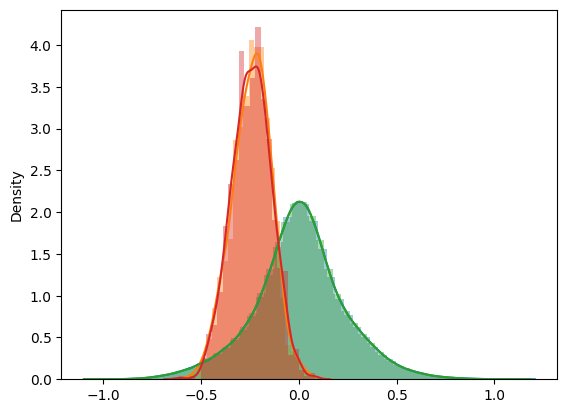

In [67]:
sns.distplot(svi_samples_prior['linear.weight'])
sns.distplot(svi_samples_prior['linear.bias'])

sns.distplot(svi_samples['linear.weight'])
sns.distplot(svi_samples['linear.bias'])